In [75]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
#import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier


import re
import time

import re
import nltk
import spacy
import tensorflow


In [2]:
#downloading the nltk stopwords
#nltk.download('stopwords')

We load the two dataset we want to analyze. We want to combine these two by the unnamed:0 column and remove it.

In [3]:
df = pd.read_csv('./Data/restaurant_data')
target_df = pd.read_csv('./Data/target_data')

In [4]:
target_df.head()

,Unnamed: 0,target
0,326679,1
1,356839,1
2,257508,1
3,103858,1
4,282703,0


In [5]:
restaurants_df = df.merge(target_df,
                         how = 'inner',
                         left_on = ['Unnamed: 0'],
                         right_on = ['Unnamed: 0']
                         )
restaurants_df.drop('Unnamed: 0' , axis=1,inplace =True)

In [6]:
restaurants_df.head()

,user_id,prod_id,rating,date,review,name,target
0,22558,859,5.0,2007-05-28,Looking for some authentic Japanese food at re...,Yakitori Totto,1
1,78837,915,4.0,2009-10-05,Pepe Rosso is where you go when you're in SOHO...,Pepe Rosso To Go,1
2,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1
3,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1
4,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0


In [7]:
#%%time
# CPU times: user 162 ms, sys: 55.7 ms, total: 217 ms
# Wall time: 218 ms



#create a list which contains all reviews all in lowercase

all_reviews = []
for review in restaurants_df['review']:
    all_reviews.append(review.lower())
#all_reviews

#turn the list into a string
all_reviews_str = ' '.join(map(str, all_reviews))

In [8]:
all_reviews_str[:1000]

"looking for some authentic japanese food at reasonable prices? this is the place to go. \xa0we went there \xa0based off of some recommendations from japanes nationals. the food is amazing. all the skewers are really good (ive had about 15 different ones on the menu in multiple sittings). everything is so flavorful. oh, and nothing beats winding down a long day with a nice cold sappporo reserve :) pepe rosso is where you go when you're in soho or the honkytonk part of the village near nyu and you just want to find a quick, affordable, no-frills, hearty meal. \xa0this is a real neighborhood place, off the tourist radar. \xa0it is called pepe rosso to go for a reason, as the seating is very limited and quite cramped. \xa0if you want to sit down and eat there, you know what you are getting yourself into. \xa0as long as you accept the close company and see it as part of the pepe's charm, you will have a good experience. \xa0also remember you are in soho, so there is always a classic nyc st

In [9]:
# %%time
# CPU times: user 6.21 s, sys: 823 ms, total: 7.03 s
# Wall time: 7.03 s



#strip some punctuation
all_rev_wo_punc = [word.strip(string.punctuation) for word in all_reviews_str.split(" ")]

In [10]:
all_words_df = pd.DataFrame(all_rev_wo_punc, columns = ['words'])

In [11]:
all_words_df['index'] = 0

In [12]:
# %%time
# CPU times: user 2.55 s, sys: 360 ms, total: 2.91 s
# Wall time: 2.9 s

top_15_words_first_ver = all_words_df.groupby("words").count().sort_values(by= 'index', ascending = False).head(15)

In [13]:
top_15_words_first_ver['index'] = top_15_words_first_ver['index']/1000000

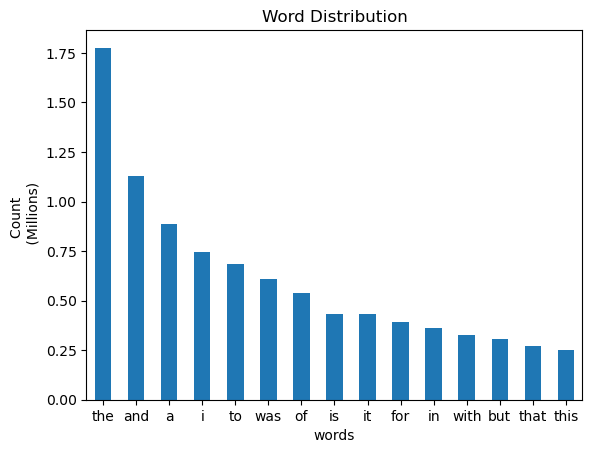

In [14]:
axes = top_15_words_first_ver.plot(kind = "bar",
                                   rot = 0, 
                                   legend = False, 
                                   ylabel = 'Count \n (Millions)',
                                   title = 'Word Distribution',
                                   grid = False
                                  );
plt.show();

In [15]:
restaurants_df.head()

,user_id,prod_id,rating,date,review,name,target
0,22558,859,5.0,2007-05-28,Looking for some authentic Japanese food at re...,Yakitori Totto,1
1,78837,915,4.0,2009-10-05,Pepe Rosso is where you go when you're in SOHO...,Pepe Rosso To Go,1
2,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1
3,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1
4,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0


Our goal is to see if a review if fraud or not so the only two key values we need to look at is the target and the review. We create a new data called corpus for analysis.

In [16]:
corpus = restaurants_df.drop(['user_id','prod_id','rating','date','name'],axis = 1)

In [17]:
corpus

,review,target
0,Looking for some authentic Japanese food at re...,1
1,Pepe Rosso is where you go when you're in SOHO...,1
2,I had waited to return a couple other times to...,1
3,This place is always busy - partly because it'...,1
4,Love this place! I am not a regular yelper I d...,0
...,...,...
285989,Noodle taste great. Its nice and chewy. Im suc...,1
285990,Despite frequently visiting and previously liv...,1
285991,Definitely a place to come for a good dinner o...,1
285992,"At first, I didn't know if I enjoyed this food...",1


Let's take a closer look at a sample text chosen at random. There are a few items capitalized, a bunch of punctuations as well.

In [18]:
test_doc = corpus.loc[3].review

In [19]:
sw = stopwords.words('english')

In [20]:
#\$\d+(?:\.\d+)?

#\$: ensures dollar sign followed by

#\d+: more or one digits

#(?:\.\d+)?: decimal part which is optional

In [21]:
corpus.head()

,review,target
0,Looking for some authentic Japanese food at re...,1
1,Pepe Rosso is where you go when you're in SOHO...,1
2,I had waited to return a couple other times to...,1
3,This place is always busy - partly because it'...,1
4,Love this place! I am not a regular yelper I d...,0


In [22]:
import nltk
#from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
def text_cleaning(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [23]:
corpus_clean = corpus.copy()

In [24]:
%%time

corpus_clean['review'] = corpus['review'].apply(text_cleaning)

CPU times: user 32.1 s, sys: 467 ms, total: 32.5 s
Wall time: 32.5 s


In [25]:
corpus_clean

,review,target
0,looking for some authentic japanese food at re...,1
1,pepe rosso is where you go when you re in soho...,1
2,i had waited to return a couple other times to...,1
3,this place is always busy partly because it ...,1
4,love this place i am not a regular yelper i d...,0
...,...,...
285989,noodle taste great its nice and chewy im suc...,1
285990,despite frequently visiting and previously liv...,1
285991,definitely a place to come for a good dinner o...,1
285992,at first i didn t know if i enjoyed this food...,1


In [26]:
data = corpus_clean.review
target = corpus_clean.target

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                   target,
                                                   random_state =42,
                                                   stratify = target
                                                  )

In [61]:
len(X_test)

71499

In [60]:
len(y_test)


71499

In [28]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [29]:
dummy_clf.predict(X_train)
dummy_clf.score(X_train,y_train)

0.8982260658756615

In [66]:
cv = CountVectorizer(ngram_range=(1,2))
X_vec_train = cv.fit_transform(X_train)
X_vec_test = cv.transform(X_test)

In [37]:
#%%time
#CPU times: user 1h 24min 43s, sys: 14min 8s, total: 1h 38min 51s
#Wall time: 14min 52s

model = LogisticRegression(C=2,max_iter= 100000)
model.fit(X_vec_train, y_train)

CPU times: user 1h 24min 43s, sys: 14min 8s, total: 1h 38min 51s
Wall time: 14min 52s


LogisticRegression(C=2, max_iter=100000)

In [67]:
predicted_train = model.predict(X_vec_train)

In [68]:
accuracy_value_train = roc_auc_score(y_train, predicted_train)
print(accuracy_value_train)

0.9764232783843093


In [70]:
predicted_test = model.predict(X_vec_test)
accuracy_value_test = roc_auc_score(y_test, predicted_test)

In [71]:
print(accuracy_value_test)

0.534475940516677


## MODEL #2

In [76]:
from nltk import word_tokenize

In [91]:
corpus.columns
corpus['wo_stopwords'] = corpus['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

In [92]:
corpus

,review,target,wo_stopwords
0,Looking for some authentic Japanese food at re...,1,Looking authentic Japanese food reasonable pri...
1,Pepe Rosso is where you go when you're in SOHO...,1,Pepe Rosso go SOHO honkytonk part Village near...
2,I had waited to return a couple other times to...,1,I waited return couple times give assessment E...
3,This place is always busy - partly because it'...,1,This place always busy - partly tiny. But none...
4,Love this place! I am not a regular yelper I d...,0,Love place! I regular yelper I write review mu...
...,...,...,...
285989,Noodle taste great. Its nice and chewy. Im suc...,1,Noodle taste great. Its nice chewy. Im noodle ...
285990,Despite frequently visiting and previously liv...,1,Despite frequently visiting previously living ...
285991,Definitely a place to come for a good dinner o...,1,Definitely place come good dinner lunch. Actua...
285992,"At first, I didn't know if I enjoyed this food...",1,"At first, I know I enjoyed food simply I buzze..."


In [93]:
corpus['wo_stopwords'] = corpus['wo_stopwords'].apply(text_cleaning)

In [94]:
corpus

,review,target,wo_stopwords
0,Looking for some authentic Japanese food at re...,1,looking authentic japanese food reasonable pri...
1,Pepe Rosso is where you go when you're in SOHO...,1,pepe rosso go soho honkytonk part village near...
2,I had waited to return a couple other times to...,1,i waited return couple times give assessment e...
3,This place is always busy - partly because it'...,1,this place always busy partly tiny but none...
4,Love this place! I am not a regular yelper I d...,0,love place i regular yelper i write review mu...
...,...,...,...
285989,Noodle taste great. Its nice and chewy. Im suc...,1,noodle taste great its nice chewy im noodle ...
285990,Despite frequently visiting and previously liv...,1,despite frequently visiting previously living ...
285991,Definitely a place to come for a good dinner o...,1,definitely place come good dinner lunch actua...
285992,"At first, I didn't know if I enjoyed this food...",1,at first i know i enjoyed food simply i buzze...


In [98]:
data2 = corpus.wo_stopwords
target2 = corpus.target

In [99]:
X_train, X_test, y_train, y_test = train_test_split(data2,
                                                   target2,
                                                   random_state =42,
                                                   stratify = target
                                                  )

In [100]:
X_vec_train = cv.fit_transform(X_train)
X_vec_test = cv.transform(X_test)

In [101]:
model = LogisticRegression(C=2,max_iter= 100000)
model.fit(X_vec_train, y_train)

LogisticRegression(C=2, max_iter=100000)

In [102]:
predicted_train = model.predict(X_vec_train)

In [103]:
accuracy_value_train = roc_auc_score(y_train, predicted_train)
print(accuracy_value_train)

0.9781665973370904


In [106]:
predicted_test = model.predict(X_vec_test)
accuracy_value_test = roc_auc_score(y_test, predicted_test)
print(accuracy_value_test)

0.5257223030904117


In [122]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [123]:
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline, make_pipeline

In [124]:
sm = SMOTE()

In [137]:
textclassifier =Pipeline([
       ('vect', CountVectorizer()),
       ('tfidf', TfidfTransformer()),
       ('smote', SMOTE(random_state=12)),
       ('mnb', MultinomialNB())])

In [127]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('smote', SMOTE(random_state=12)),
                ('mnb', MultinomialNB(alpha=0.1))])

In [133]:
y_pred_train = textclassifier.predict(X_train)

In [134]:
accuracy_value_train = roc_auc_score(y_train, y_pred_train)
print(accuracy_value_train)

0.759112178733617


In [135]:
 y_pred = textclassifier.predict(X_test)
    

In [136]:
accuracy_value_test = roc_auc_score(y_test, y_pred)
print(accuracy_value_test)

0.6358765582815623


In [ ]:
textclassifier.fit(X_train, y_train)

In [139]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [138]:
param_grid = { 'vect__max_df': [.85, .9, .95, 1],
               'vect__min_df': [0,.5, .1],
               'smote__k_neighbors': [3,5,7],
               'mnb__alpha': [.1,.25,.5,.75,1]
             }


In [140]:
gs = GridSearchCV(textclassifier, param_grid, cv=5, scoring='f1')

In [146]:
#%%time
#gs.fit(X_train,y_train)

232117    had great experience here  food outstanding  l...
130744    the atmosphere place great  we group  people a...
191367    red  white   blue  if know love raw bar  go fi...
267591    pretty mediocre  seasoning often done heavy hand 
3435      crabs want crabs get  this place practically w...
                                ...                        
36391     waited write review every time i thought place...
55372     my favorite italian restaurant  maybe i enjoy ...
96484     it busy friday morning place packed   how peop...
82098     think got lucky  mins wait friday night    tim...
176836    rewrite     yes burgers that good          i r...
Name: wo_stopwords, Length: 214495, dtype: object

In [151]:
#####

corpus_z = corpus[['target','wo_stopwords']]

In [214]:
true_BoW = corpus_z[corpus_z['target'] == 1]

In [215]:
false_BoW = corpus_z[corpus_z['target'] == 0]

In [217]:
f_LoW = []
for i in false_BoW["wo_stopwords"]:
    f_LoW.append(i)

In [219]:
t_LoW = []
for i in true_BoW["wo_stopwords"]:
    t_LoW.append(i)

In [220]:


t_words = ' '.join(map(str, t_LoW))
f_words = ' '.join(map(str, f_LoW))

In [223]:
t_words[:1000]

'looking authentic japanese food reasonable prices  this place go  we went based recommendations japanes nationals  the food amazing  all skewers really good  ive  different ones menu multiple sittings   everything flavorful  oh  nothing beats winding long day nice cold sappporo reserve    pepe rosso go soho honkytonk part village near nyu want find quick  affordable  no frills  hearty meal  this real neighborhood place  tourist radar  it called pepe rosso to go reason  seating limited quite cramped  if want sit eat there  know getting into  as long accept close company see part pepe s charm  good experience  also remember soho  always classic nyc stoop stair nearby nice nights  sitting stoop penne true nyc experience  especially views empire state building sullivan st  service fairly quick whether dining taking out  i pasta dishes tasty  al dente pasta  good natural sauce  lots real garlic  plus bread   all all  great place delicious  cheap bite eat  i m big fan  no diet coke  skim mi

In [222]:
f_words[:1000]

'love place  i regular yelper i write review much  i fan thai place i eating  years  they good restaurant  great food polite service  restaurant looks clean  i picky food always make happy food i like spicy less oil  if want authentic thai food crowded i recommend  you get table easily great dinner  try crying udon noodle  my favorite menu  if filipino  expect pay     good meal  you mom know cost   something dollars cook adobo  pusit  palabok  kare kare  bokchoy      oh yeah i forget mention individually plated    food mediocre  seem much fusion  the server nerve ask us wanted double orders    hahah watta guy all all  bit overpriced know much something really cost  best grilled cheese sandwiches world  always go back  hands down  favorite park slope haunt  fun bar  festive atmosphere  unfailingly delicious food  i rarely eat fish  yet bogota  i always order it  they blue corn crusted trout occasionally would knock socks off  and i salivate thinking empanadas  seriously  their food also

In [224]:
T_W = [word.strip(string.punctuation) for word in t_words.split(" ")]
F_W = [word.strip(string.punctuation) for word in f_words.split(" ")]

In [230]:
t_w_df = pd.DataFrame(T_W, columns = ['words'])
f_w_df = pd.DataFrame(F_W, columns = ['words'])

In [233]:
t_w_df['index'] = 0
f_w_df['index'] = 0

In [234]:
top_t_w = t_w_df.groupby("words").count().sort_values(by= 'index', ascending = False)
top_f_w = f_w_df.groupby("words").count().sort_values(by= 'index', ascending = False)

In [241]:
# top_t_w.to_csv('top_true')
# top_f_w.to_csv('top_false')

In [239]:
top_t_w.head(20)

,index
words,
,5342463
i,847935
the,330600
good,179278
it,178415
food,176594
place,165474
s,144817
great,123553


In [240]:
top_f_w.head(20)

,index
words,
,394372
i,61730
the,26112
food,20289
place,16222
good,14069
great,13698
it,12275
s,9719


In [190]:
W2 = [word.strip(string.punctuation) for word in words.split(" ")]

In [191]:
all_w2_df = pd.DataFrame(W2, columns = ['words'])

In [192]:
all_w2_df

,words
0,looking
1,authentic
2,japanese
3,food
4,reasonable
...,...
25950265,back
25950266,second
25950267,time
25950268,soon


In [213]:
all_w2_df['index'] = 0
top_15_words_f_ver = all_w2_df.groupby("words").count().sort_values(by= 'index', ascending = False)

In [210]:
t2 = top_15_words_first_ver = all_words_df.groupby("words").count().sort_values(by= 'index', ascending = False)

In [212]:
t2.iloc[20: ,:]

,index
words,
,194333
food,192484
good,189444
were,189056
not,188164
...,...
hyper-sweet,1
hyper-tiny,1
hyper-tomato-y,1


In [194]:
top_15_words_f_ver

,index
words,
,5736835
i,909665
the,356712
food,196883
good,193347
it,190690
place,181696
s,154536
great,137251


In [ ]:
# %%time
# CPU times: user 2.55 s, sys: 360 ms, total: 2.91 s
# Wall time: 2.9 s
all_words_df = pd.DataFrame(all_rev_wo_punc, columns = ['words'])
all_words_df['index'] = 0
top_15_words_first_ver = all_words_df.groupby("words").count().sort_values(by= 'index', ascending = False).head(15)

ValueError: DataFrame constructor not properly called!

In [187]:
all_w2_df['index'] = 0
top_15_words_first_ver = all_words_df.groupby("words").count().sort_values(by= 'index', ascending = False).head(15)

ValueError: DataFrame constructor not properly called!

In [116]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'had great experience here  food outstanding  love open kitchen  wine list fantastic  bar tender great  let try mead ordering glass   mead selection   nice vibe place  service i like it  polite unobtrusive  detracting evening all  i coming back '

In [77]:
# word_tokenize

<function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>

In [ ]:
# def custom_tokenize(text):
#     text = clean_text(text)
#     tokens = custom_tokenizer(text)
#     return tokens

In [78]:
# from sklearn.feature_extraction.text import CountVectorizer

In [81]:
# sp = spacy.load("en_core_web_sm")

In [82]:
# doc = sp('some random text I am testing, what does this do?')

In [85]:
# for token in doc:
#     #print(token.text, token.pos_,token.dep_)
#     print(token.text)

some
random
text
I
am
testing
,
what
does
this
do
?


In [ ]:
vect = CountVectorizer(max_features = None,
                      tokenizer = renltk_tokenize,
                      ngram_range = (1,1),
                      lowercase =True
                      )

In [ ]:
x_train = cv.fit_transform(X_train)

In [ ]:
x_train

In [ ]:
y_train

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()

In [ ]:
nb.fit(X_train, y_train)

In [ ]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw]
    return stopwords_removed    

In [ ]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [ ]:
processed_data = list(map(process_article, XXXXXX))

In [ ]:
processed_data

In [ ]:
first_item = restaurants_df['review'][0]
first_item

In [ ]:
first_item = first_item.lower()
first_item

In [ ]:
[word.strip(string.punctuation) for word in first_item.split(" ")]